# Evaluate labour productivity loss 


In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.CRITICAL)

import glob
import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import pandas as pd
import cartopy.feature as cfeature

In [3]:
# Variable specific settings
var = 'productivityLoss'
name = 'productivity loss'
units = ''
cmap = 'RdBu_r'

inst = "BOM" #"BOM" #"CSIRO"
if inst =="CSIRO":
    version = "v20251120"
else:
    version = "v20250901"
    
gcm= "ACCESS-CM2"
run = "r4i1p1f1"

rcm = "BARPA-R" #"BARPA-R" #"CCAM-v2203-SN"
yr_start ="1980-01-01"
yr_end ="2014-12-31"
reference = "BARRA-R2"
ssp = "ssp126"
start_date_fut = '2065-01-01'
end_date_fut = '2099-12-31'

In [4]:
# histirical data
path_ref= f"/scratch/xv83/at2708/productivityLoss/AUST-11/BOM/ERA5/historical/hres/BARRAR2/v1/1hr/productivityLoss/v20250901-native-contiguous/"
path_correct_model = f"/scratch/xv83/at2708/productivityLoss/AUST-11i/{inst}/{gcm}/historical/{run}/{rcm}/v1-r1-ACS-QME-BARRAR2-1980-2022/1hr/productivityLoss/{version}/"
files_ref= glob.glob(path_ref + '*.nc')
files_correct_model= glob.glob(path_correct_model + '*.nc')

da_ref_low = xr.open_mfdataset(files_ref, engine='h5netcdf',chunks={}).productivity_loss_low.sel(time=slice(yr_start,yr_end))#.pipe(lambda da: da.sel(time=da.time.dt.hour == 3))
da_ref_medium = xr.open_mfdataset(files_ref, engine='h5netcdf',chunks={}).productivity_loss_medium.sel(time=slice(yr_start,yr_end))#.pipe(lambda da: da.sel(time=da.time.dt.hour == 3))
da_ref_high = xr.open_mfdataset(files_ref, engine='h5netcdf',chunks={}).productivity_loss_high.sel(time=slice(yr_start,yr_end))#.pipe(lambda da: da.sel(time=da.time.dt.hour == 3))

da_correct_model_low = xr.open_mfdataset(files_correct_model, engine='h5netcdf',chunks={}).productivity_loss_low.sel(time=slice(yr_start,yr_end))#.pipe(lambda da: da.sel(time=da.time.dt.hour == 3))
da_correct_model_medium = xr.open_mfdataset(files_correct_model, engine='h5netcdf',chunks={}).productivity_loss_medium.sel(time=slice(yr_start,yr_end))#.pipe(lambda da: da.sel(time=da.time.dt.hour == 3))
da_correct_model_high = xr.open_mfdataset(files_correct_model, engine='h5netcdf',chunks={}).productivity_loss_high.sel(time=slice(yr_start,yr_end))#.pipe(lambda da: da.sel(time=da.time.dt.hour == 3))






## Load productivity loss for three different physical intensities

In [5]:
ref_low = da_ref_low.compute()
corrected_low = da_correct_model_low.compute()

In [6]:
ref_medium = da_ref_medium.compute()
corrected_medium = da_correct_model_medium.compute()

In [7]:
ref_high = da_ref_high.compute()
corrected_high = da_correct_model_high.compute()

In [8]:
ref_low = ref_low * -100
corrected_low = corrected_low * -100

In [9]:
ref_medium = ref_medium * -100
corrected_medium = corrected_medium * -100

In [ ]:
ref_high = ref_high * -100
corrected_high = corrected_high * -100

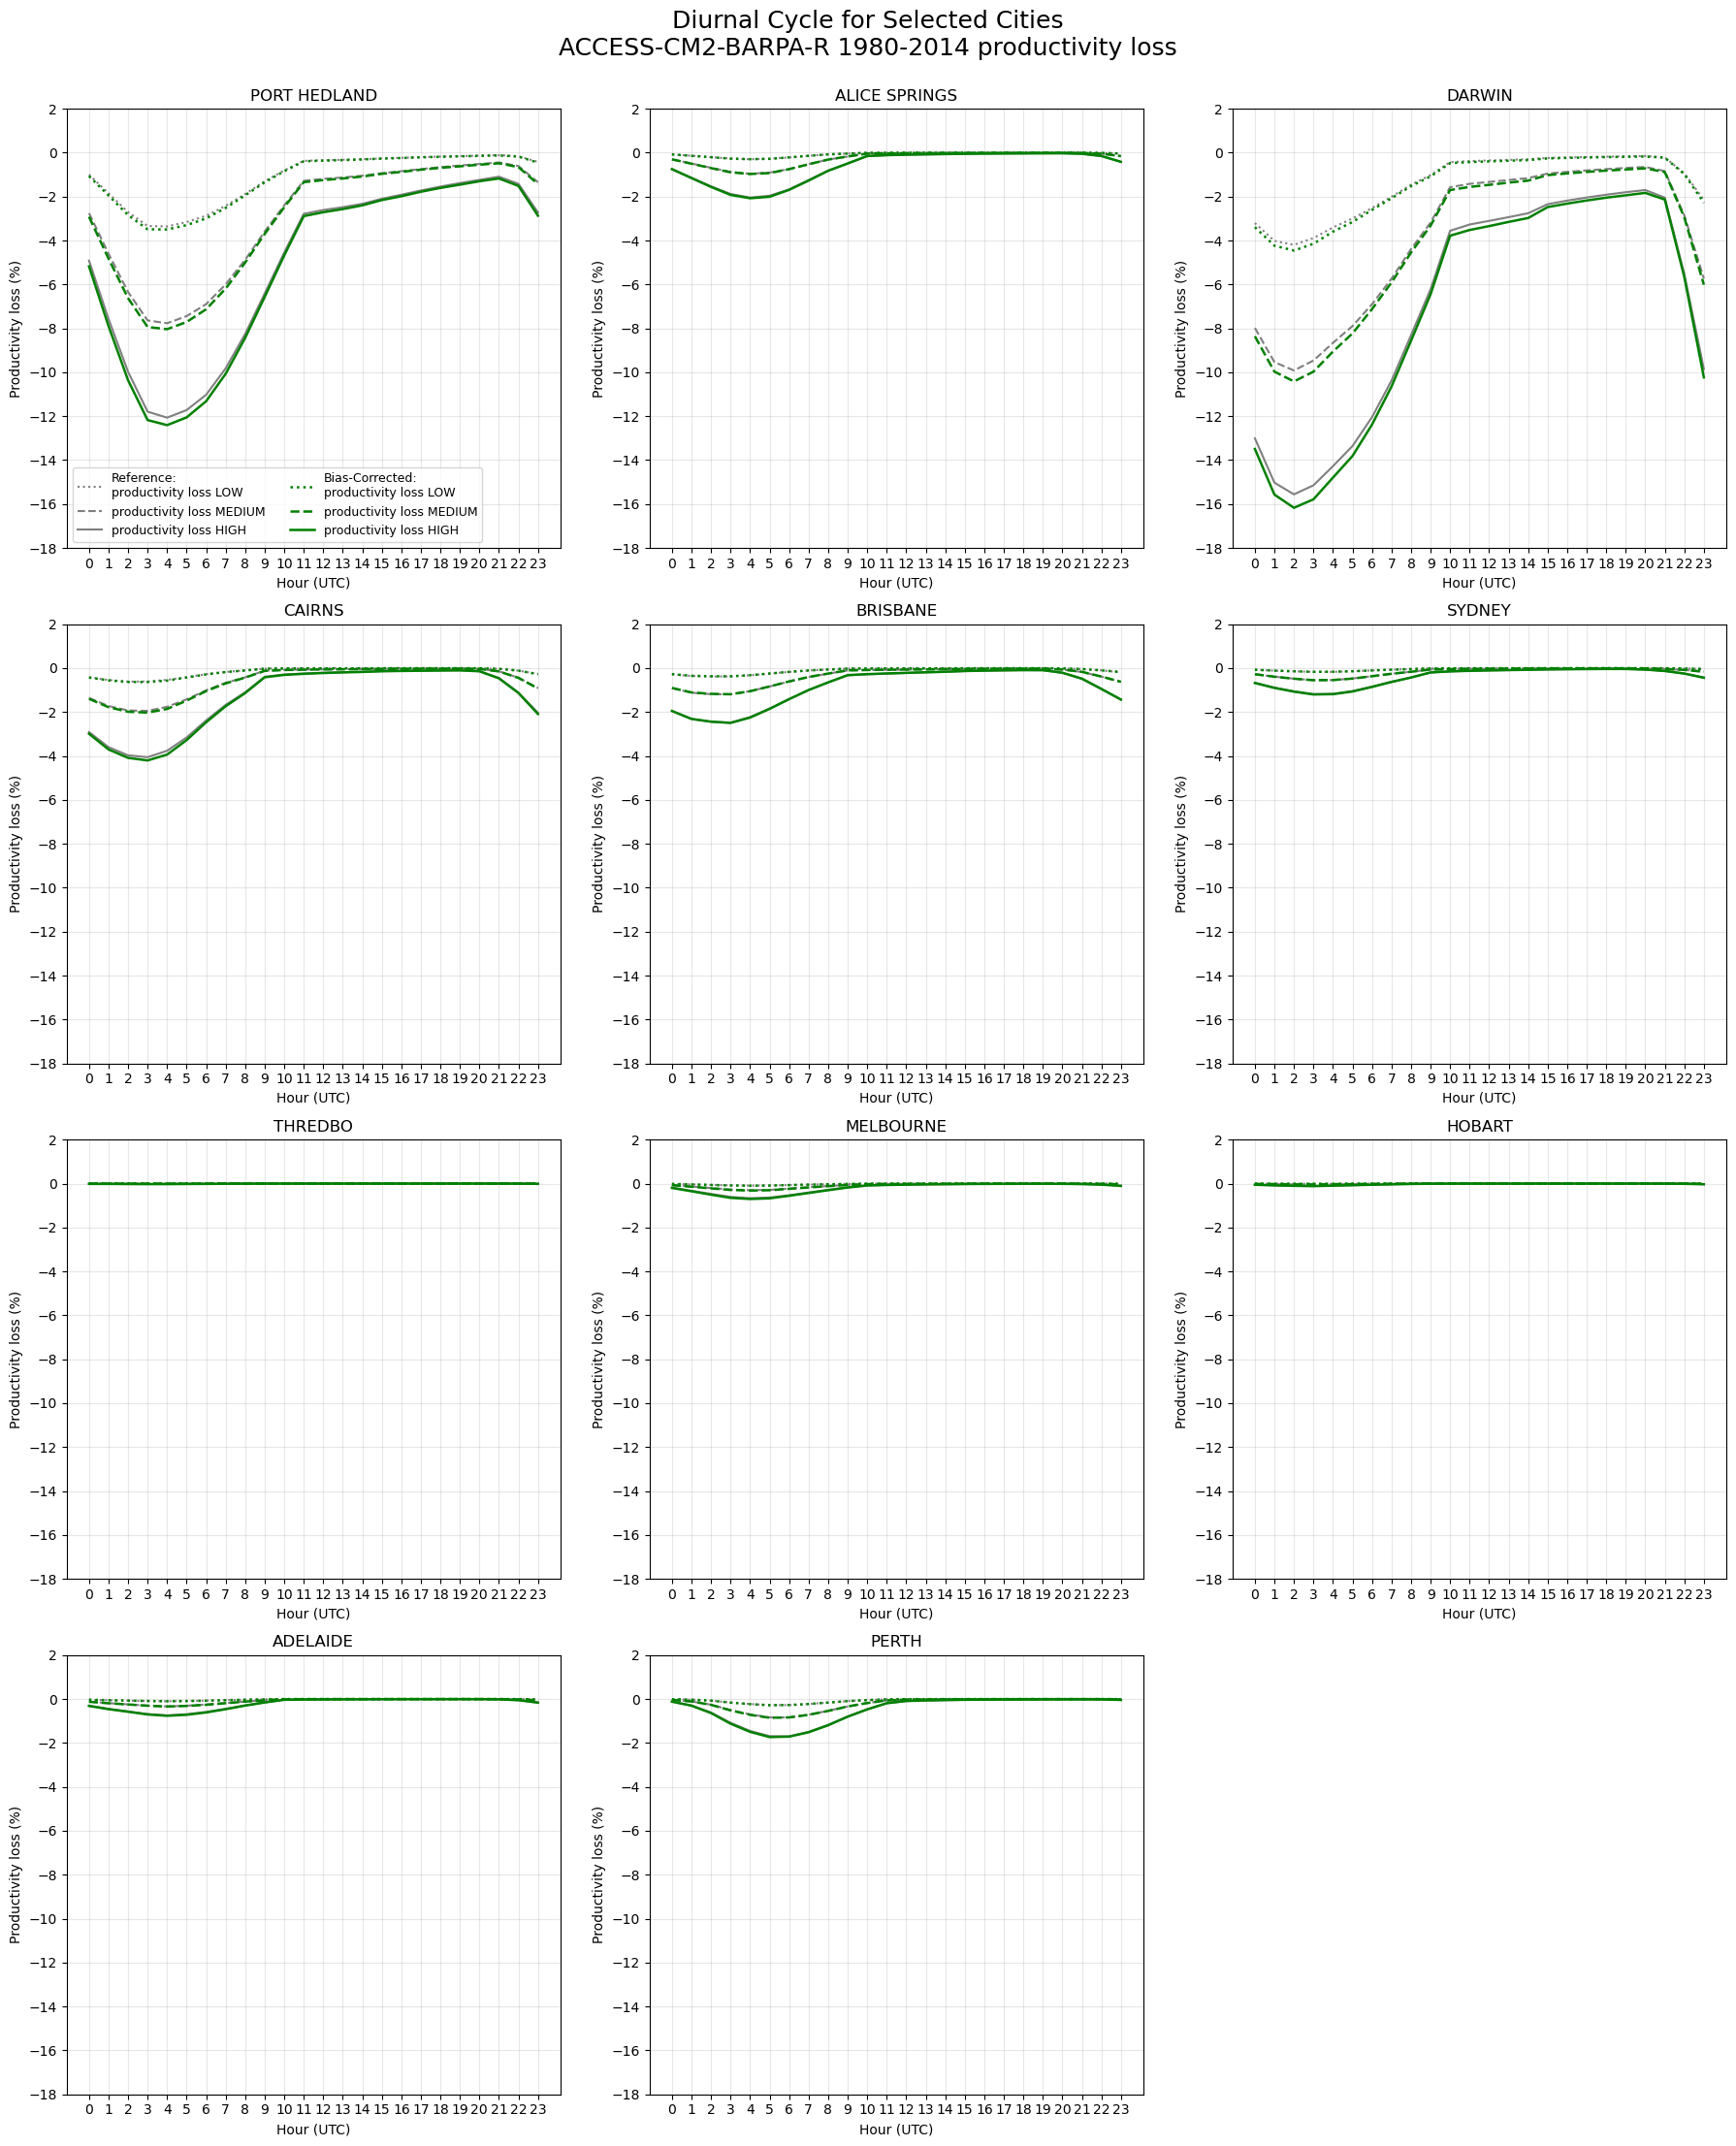

Saved: /scratch/xv83/at2708/productivityLoss/evaluation/productivityLoss_diurnal-cycle-cities_productivityLoss_1980-2014_ACCESS-CM2_BARPA-R.png


In [16]:
# Plot city-based diurnal cycle of productivity loss

cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},
}

def build_diurnal_df(ref, corrected, cities):
    results = []
    for city, coords in cities.items():    
        # Select nearest grid point for each dataset
        ref_city = ref.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
        corrected_city = corrected.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
    
        # Convert to pandas
        df_city = pd.DataFrame({
            'reference': ref_city.values,
            'bias_corrected': corrected_city.values
        }, index=pd.to_datetime(ref_city['time'].values))
    
        # Compute hourly means for diurnal cycle
        for hour in range(24):
            subset = df_city[df_city.index.hour == hour]
            hourly_ref = subset['reference'].mean()
            hourly_bc = subset['bias_corrected'].mean()
            results.append([hour, city, hourly_ref, hourly_bc])
    
    diurnal_df = pd.DataFrame(results, columns=['Hour', 'City', 'Hourly_Ref', 'Hourly_BC'])
    return diurnal_df

# Diurnal cycle plot setup
task = "diurnal-cycle-cities_productivityLoss"
calc = "diurnal cycle cities"

# Build diurnals for LOW / MEDIUM / HIGH
diurnal_low    = build_diurnal_df(ref_low,    corrected_low,    cities)
diurnal_medium = build_diurnal_df(ref_medium, corrected_medium, cities)
diurnal_high   = build_diurnal_df(ref_high,   corrected_high,   cities)

# Get list of cities
cities_list = diurnal_low['City'].unique()
n_cities = len(cities_list)

# Plot grid
cols = 3
rows = (n_cities + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

# global y-axis limits 
y_min = float(min(
    diurnal_low[['Hourly_Ref', 'Hourly_BC']].min().min(),
    diurnal_medium[['Hourly_Ref', 'Hourly_BC']].min().min(),
    diurnal_high[['Hourly_Ref', 'Hourly_BC']].min().min(),
))
y_max = float(max(
    diurnal_low[['Hourly_Ref', 'Hourly_BC']].max().max(),
    diurnal_medium[['Hourly_Ref', 'Hourly_BC']].max().max(),
    diurnal_high[['Hourly_Ref', 'Hourly_BC']].max().max(),
))
y_min_pad = np.floor(y_min / 2) * 2
y_max_pad = np.ceil((y_max + 2) / 2) * 2

# Line styles per level
styles = {
    'LOW': ':',
    'MEDIUM': '--',
    'HIGH': '-'
}

for i, city in enumerate(cities_list):
    ax = axes[i]
    dl = diurnal_low[diurnal_low['City'] == city]
    dm = diurnal_medium[diurnal_medium['City'] == city]
    dh = diurnal_high[diurnal_high['City'] == city]

    # Reference for LOW / MEDIUM / HIGH productivity loss
    ax.plot(dl['Hour'], dl['Hourly_Ref'], color='grey',  linewidth=1.5, linestyle=styles['LOW'],    label='Reference:\nproductivity loss LOW')
    ax.plot(dm['Hour'], dm['Hourly_Ref'], color='grey',  linewidth=1.5, linestyle=styles['MEDIUM'], label='productivity loss MEDIUM')
    ax.plot(dh['Hour'], dh['Hourly_Ref'], color='grey',  linewidth=1.5, linestyle=styles['HIGH'],   label='productivity loss HIGH')

    # Bias-corrected for LOW / MEDIUM / HIGH productivity loss
    ax.plot(dl['Hour'], dl['Hourly_BC'], color='green', linewidth=1.8, linestyle=styles['LOW'],    label='Bias-Corrected:\nproductivity loss LOW')
    ax.plot(dm['Hour'], dm['Hourly_BC'], color='green', linewidth=1.8, linestyle=styles['MEDIUM'], label='productivity loss MEDIUM')
    ax.plot(dh['Hour'], dh['Hourly_BC'], color='green', linewidth=1.8, linestyle=styles['HIGH'],   label='productivity loss HIGH')

    ax.set_title(city.upper())
    ax.set_xlabel('Hour (UTC)')
    ax.set_ylabel('Productivity loss (%)')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(24))
    ax.set_yticks(np.arange(y_min_pad, y_max_pad + 0.1, 2))
    ax.set_ylim(y_min_pad, y_max_pad)

    if i == 0:
        ax.legend(ncol=2, fontsize=9)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle(
    f"Diurnal Cycle for Selected Cities\n{gcm}-{rcm} {yr_start.split('-')[0]}-{yr_end.split('-')[0]} {name}",
    fontsize=18, y=0.95
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

outfile = f"/scratch/xv83/at2708/productivityLoss/evaluation/{var}_{task}_{yr_start.split('-')[0]}-{yr_end.split('-')[0]}_{gcm}_{rcm}.png"
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {outfile}")